![dota banner.jpeg](<attachment:dota banner.jpeg>)

## Abstract
We forecast weekly maximum player counts for the Multiplayer Online Battle Arena (MOBA) game Dota 2 via an ARIMA model. The data can be found here: https://steamdb.info/app/570/charts/#max. In Sections 1–3, we examine the data, clean it, and examine it for stationarity. The data is deemed non-stationary, so we process it in Section 4 by computing annualized normalizations and considering first differences of these values. In Section 5, we use auto_arima to deduce an ARIMA model order of (2,0,3), and we make summary remarks in Section 6.

## Table of Contents
1. [Preliminary Remarks](#preliminary_remarks) 
2. [Data Cleaning](#data_cleaning)
3. [Assessing Stationarity](#assessing_stationarity)
4. [Transforming the Model](#transforming_data)
5. [Establishing a Model](#establishing_model)  
6. [Conclusion](#conclusion)
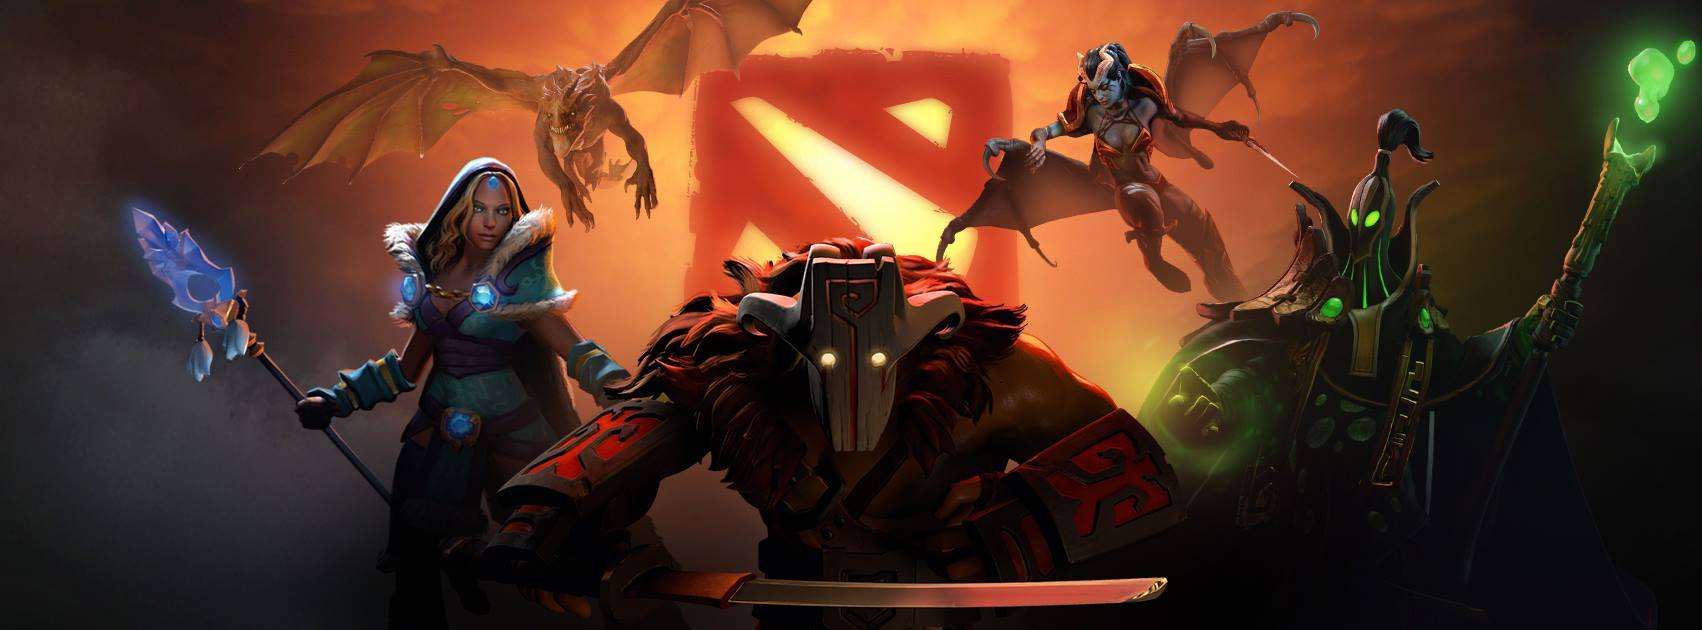

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import re
import datetime

import catppuccin                                           
from catppuccin.extras.matplotlib import load_color         

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from pmdarima.arima import auto_arima

### Preliminary Remarks

We begin with plotting the raw data and giving basic descriptions. Note that observations increase in frequency toward the end: polling turns from daily to hourly to every ten minutes in more recent months. The daily observations from older months appear to be maximum daily player counts. 

You may adjust the size of all plots for this notebook in the cell below. Deleting any lines involving the catppuccin style may cause errors plot rendering.

In [ ]:
size=(22,12) 
mpl.style.use(["ggplot", catppuccin.PALETTE.mocha.identifier])
%config InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
df = pd.read_csv('dotachart.csv')
df.head()
df.tail()
df.describe()

In [ ]:
df.plot(title='Dota 2 Player Count', figsize=size)

### Data Cleaning <a class="anchor" id="data_cleaning"></a>

First, we will reduce to daily observations, using maximum player counts for days with hourly observations. We will also re-index the data using the dates as indices. We scale the data by a factor of 1/1000 for clarity.

In [ ]:
max_daily = df.copy()

In [ ]:
max_daily.set_index(max_daily['DateTime'], inplace=True)
max_daily.drop(columns=['DateTime'], inplace=True)
max_daily.index = pd.DatetimeIndex(max_daily.index)  #running this cell twice in a row will throw an error

In [ ]:
type(max_daily)

In [ ]:
temp_list=[]
for d in max_daily.index:
    temp_list.append(np.max(max_daily.loc[d.strftime('%Y-%m-%d')])/1000)

max_daily['Max. Players (Thousands)'] = temp_list

max_daily.drop(columns=['Players'], inplace=True)
max_daily.drop_duplicates(inplace=True)

max_daily.tail()

In [ ]:
max_daily.index = pd.DatetimeIndex(max_daily.index).to_period('D')

In [ ]:
max_daily.plot(title='Dota 2 Player Count (in thousands)', figsize=size); max_daily.describe()

### Assessing Stationarity <a class="anchor" id="assessing_stationarity"></a>

A priori, it appears that the data is non-stationary. There appears to be an upward trend in the mean. The variance appears to be somewhat constant across certain years, but the large spikes make visual assessment unclear.

Although it has a significant p-value from the Augmented Dickey-Fuller Test (ADFT), the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots visually indicate non-stationarity. The ACF and PACF plots appear to indicate seasonality with a lag of seven months. However, examining the first difference with a lag of seven does not yield more useful ACF and PACF plots.

In [ ]:
adfuller(max_daily.dropna())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=size)

plot_acf(max_daily.dropna(), alpha=.01, ax=ax[0]); plot_pacf(max_daily.dropna(), alpha=.01, ax=ax[1]);

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=size)
plot_acf(max_daily.diff(7).dropna(), alpha=.01, ax=ax[0]); plot_pacf(max_daily.diff(7).dropna(), alpha=.01, ax=ax[1]);

### Transforming Data <a class="anchor" id="transforming_data"></a>

Let us transform the data in hopes of securing more stationary observations. We will compute weekly averages and plot this against the daily player counts. Further, we normalize this data relative to the year in which it occurs. We will refer to these as _annualized Z-scores_. That is, for a given weekly average we compute 

$$Z_\text{annual} = \frac{\text{weekly average} - \text{annual average}}{\text{annual standard deviation}}$$

Finally, we plot the weekly averages, their annualized Z-scores, as well as the ACF and PACF plots of the annualized Z-scores and the first differences of the annualized Z-scores.

In [ ]:
weekly_avg = max_daily.copy()
weekly_avg.index = weekly_avg.index.to_timestamp().to_period('W')
weekly_avg = weekly_avg.groupby(['DateTime']).mean()
weekly_avg.rename(columns={'Players' : 'Avg Weekly Players'}, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=size)
ax2=ax.twiny()

max_daily.plot(ax=ax).legend(labels=['Daily Max Player Count'], loc='upper right')
weekly_avg.plot(ax=ax2, color=load_color(catppuccin.PALETTE.mocha.identifier, "peach")).legend(labels=['Weekly Average'],loc='upper left')

In [ ]:
annual_volatility_series = max_daily['Max. Players (Thousands)'].groupby(max_daily.index.year).std()
annual_volatility = weekly_avg.index.map(lambda d: annual_volatility_series.loc[d.year])

annual_mean_series = max_daily['Max. Players (Thousands)'].groupby(max_daily.index.year).mean()
annual_mean = weekly_avg.index.map(lambda d: annual_mean_series.loc[d.year])

In [ ]:
norm_weekly_avg = ((weekly_avg['Max. Players (Thousands)'] - annual_mean)/annual_volatility).to_frame()
norm_weekly_avg.rename(columns={'Max. Players (Thousands)' : 'Annualized Z-scores of Weekly Averages'}, inplace=True)

In [ ]:
fig = plt.figure(figsize=size)

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

norm_weekly_avg.plot(ax=ax1, title='Annualized Z-scores')

suppress_output_0 = plot_acf(norm_weekly_avg.dropna(), alpha=.01, ax=ax2)
suppress_output_1 = plot_pacf(norm_weekly_avg.dropna(), alpha=.01, ax=ax3)


print('Annualized Z-Scores ADF Test')
adfuller(norm_weekly_avg.dropna())
plt.show()

In [ ]:
fig = plt.figure(figsize=size)

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

norm_weekly_avg.plot(ax=ax1, title='Annualized Z-scores, First Difference')

suppress_output_0 = plot_acf(norm_weekly_avg.diff().dropna(), alpha=.01, ax=ax2)
suppress_output_1 = plot_pacf(norm_weekly_avg.diff().dropna(), alpha=.01, ax=ax3)


print('Annualized Z-Scores, First Difference ADF Test')
adfuller(norm_weekly_avg.diff().dropna())
plt.show()

### Establishing a Model <a class="anchor" id="establishing_model"></a>

The first differences of the normalized data appear relatively stationary, and the ADFT test-statistic is very low. The ACF and PACF plots for the first difference suggest that an ARIMA model of order (2, 1, 2) may be appropriate. The auto_arima function provides an order of (1, 1, 3), as it performs marginally better on the information criterion. We train the model on observations up through 2023. We will use this years observations as the test set.

In [ ]:
train = norm_weekly_avg[norm_weekly_avg.index.year != 2024]

In [ ]:
model = pm.auto_arima(train.dropna(),
                            start_p=0, start_q=0, start_P=0, start_Q=0,
                            max_p=6, max_q=6, max_P=6, max_Q=6, m=1, d=1, trace=True,
                            stepwise=False, alpha=.1)

In [ ]:
print(model.summary())

### Forecasting <a class="anchor" id="establishing_model"></a>

Let us apply the model to predict maximum weekly player counts in 2024. We will see that the model performs poorly on a long time-horizon (> 4 months), but performs within a reasonable margin of error for shorter periods (<= 3 months). 

Note that the model is predicting annualized Z-scores, which must be converted back into weekly maximum player counts. For this conversion, we withhold the mean and standard deviation of 2024, estimating them with the mean and standard deviation of 2023. We then compare these converted predictions to the observed values from 2024, and compute the residuals as a percentage of the observed values. 

In [ ]:
forecast = model.predict(len(test)).to_frame(name='Forecasted Values').iloc[2:]

def revert(ind, value):
    return ((val.iloc[0] * annual_volatility_series.iloc[-2]) + annual_mean_series.iloc[-2] )

for idx, val in forecast.iterrows():
    forecast.loc[idx] = revert(idx, val)


test_set = weekly_avg.loc[weekly_avg.index.year == 2024]
residuals = ((test_set['Max. Players (Thousands)'] - forecast['Forecasted Values'])/test_set['Max. Players (Thousands)']).to_frame(name='Residuals (%)')

forecast.head()

In [ ]:
fig = plt.figure(figsize=size)

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

forecast.plot(ax=ax1)
test_set.plot(ax=ax1.twiny(), color=load_color(catppuccin.PALETTE.mocha.identifier, "peach")).legend(loc='upper left')

residuals.plot(ax=ax2)
residuals.plot(ax=ax3, kind='kde')

plt.show()

In [ ]:
fig = plt.figure(figsize=size)

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

forecast.loc[forecast.index.month < 4].plot(ax=ax1)
test_set.loc[test_set.index.month < 4].plot(ax=ax1.twiny(), color=load_color(catppuccin.PALETTE.mocha.identifier, "peach")).legend(loc='upper left')

residuals.loc[residuals.index.month < 4].plot(ax=ax2)
residuals.loc[residuals.index.month < 4].plot(ax=ax3, kind='kde')

plt.show()

### Conclusions

On a less ambitious timeline, the predictions are more reasonable. They mostly lie within a 5% margin of error. However, the model has several shortcomings. For one, it is very flat and unable to account for the massive spikes that occur with a fairly regular frequency.  Additionally, the conversion of the normalized values back into a maximum player counts uses a naive approach to estimating the mean and standard deviation for 2024. A possible solution might be using rolling means and standard deviations for conversion which incorporate forecasted values. It would be interesting to see a method of anticipating large increases in volatility.

One method of enhancing the model could be using finer periods, projecting over days instead of weeks. For this, a different localized normalization would probably needed. For example, computing weekly averages and deviations and normalizing daily values relative to those. On this weekly scale, there is clear seasonality in the data since player count is highest on Saturdays and Sundays and lowest around Tuesdays as shown below.

In [ ]:
df.iloc[-1000:].plot(figsize=size)

It is also possible ARIMA is not the most appropriate method for forecasting this data set. Future projects will include time series forecasting with tensorflow in hopes of obtaining higher accuracy.